In [1]:
#--Import Necessary Library--
import sys
import math
import numpy as np
import scipy as scp
from scipy import special
from scipy import linalg
import scipy.optimize as sc
import matplotlib.pyplot as plt
import pandas as pd
import time
import re
from tqdm.auto import tqdm

# pip install scipy matplotlib pandas tqdm

# Mulai di bawah ini code untuk HLS, mohon cek dulu Pak sebelum saya rapihkan dan upload ke github

In [9]:
#--Main Integral--
def w(alpha, R):
    return alpha * R

def S(r):
    return (1 + r + ((1 / 3) * (r**2))) * np.exp(-r)


def S_(r):
    return (1 - r + ((1 / 3) * (r**2))) * np.exp(r)


def J(r):
    return -1 / r + np.exp(-2 * r) * (1 + (1 / r))


def K(r):
    return -np.exp(-r) * (1 + r)


def J_(r):
    return (1 / r) * (1 - (1 + (11 / 8) * r + (3 / 4) * (r**2) + (1 / 6) *
                           (r**3)) * np.exp(-2 * r))


def Ei(w):
    return scp.special.expi(w)

def K_(r):
    f_ = Ei(-4 * r)
    f__ = Ei(-2 * r)

    A = S_(r)
    term1 = ((25 / 8) - (23 / 4) * r - (3 * (r**2)) - (1 / 3) *
             (r**3)) * np.exp(-2 * r)
    term2 = (0.5772 + np.log(r)) * (S(r)**2)
    term3 = (A**2) * f_
    term4 = 2 * A * S(r) * f__
    try:
        return float((1 / 5) * (term1 + (6 / r) * (term2 + term3 - term4)))
    except:
        return complex((1 / 5) * (term1 + (6 / r) * (term2 + term3 - term4)))


def L(r):
    return np.exp(-r) * (r + 1 / 8 + 5 /
                         (16 * r)) + np.exp(-3 * r) * (-1 / 8 - 5 / (16 * r))

In [10]:
#--Integral and Energy--
def e_mo(alpha, R, mode, Z=1):
    """
    Mode 1: ground state
    Mode 2: doubly excited state
    """
    r = alpha * R
    T = ((alpha**2) / (1 + S(r))) * (1 - 2 * K(r) - S(r))
    Vne = Z* ((2 * alpha) / (1 + S(r))) * (-1 + J(r) + 2 * K(r))
    Vee = (alpha / (2 * ((1 + S(r))**2))) * (5 / 8 + J_(r) + 2 * K_(r) + 4 * L(r))
    Enn = Z*Z / R
    electronic_energy = T + Vne + Vee
    total_energy =  T + Vne + Vee + Enn
    if mode == 1:
        # return (Vee, T, Vne, Enn, electronic_energy, total_energy)
        return total_energy
    else:
        return ((alpha**2) / (1 - S(r))) * (1 + 2 * K(r) + S(r)) + (
            (2 * alpha) /
            (1 - S(r))) * (-1 + J(r) - 2 * K(r)) + (alpha / (2 * (
                (1 - S(r))**2))) * (5 / 8 + J_(r) + 2 * K_(r) -
                                    4 * L(r)) + 1 / R


# def KE_MO(alpha, R, mode):
#     r = alpha * R
#     if mode == 1:
#         return alpha * alpha / (1 + S(r)) * (1 - 2 * K(r) - S(r))
#     else:
#         return alpha * alpha / (1 - S(r)) * (1 + 2 * K(r) + S(r))


# def PE_MO(alpha, R, mode, Z=1):
#     r = alpha * R
    
#     if mode == 1:
#         return Z*((2 * alpha) / (1 + S(r))) * (-1 + J(r) + 2 * K(r)) + (alpha / (2 * (
#                     (1 + S(r))**2))) * (5 / 8 + J_(r) + 2 * K_(r) +
#                                         4 * L(r)) + 1 / R
#     else:
#         return ((2 * alpha) /
#                 (1 - S(r))) * (-1 + J(r) - 2 * K(r)) + (alpha / (2 * (
#                     (1 - S(r))**2))) * (5 / 8 + J_(r) + 2 * K_(r) -
#                                         4 * L(r)) + 1 / R

In [36]:
# calculate h2 energy with sto/3g using pyscf
import pyscf
from pyscf import gto, scf

x = np.round(np.arange(0.5, 3.51, 0.01), 2)

def HF_energy(R, basis='sto-3g', charge=False):
    mol = gto.Mole()
    mol.unit = 'bohr'
    mol.atom = 'H 0 0 0; H 0 0 ' + str(R)

    if charge:
        mol.charge = 2
        mol.atom = 'He 0 0 0; He 0 0 ' + str(R)

    mol.basis = basis
    mol.build()

    mf = scf.RHF(mol)
    mf.verbose = 0
    mf.kernel()
    return mf.e_tot

alpha_h2 = 1.1929

h2_sto3g = [HF_energy(i, 'sto-3g') for i in x]
h2_sto6g = [HF_energy(i, 'sto-6g') for i in x]
h2_hls = [e_mo(1.24, i, mode=1, Z=1) for i in x]
h2_hls_opt = [e_mo(alpha_h2, i, mode=1, Z=1) for i in x]

alpha_hehe = 2.1497

hehe_sto3g = [HF_energy(i, 'sto-3g', charge=True) for i in x]
hehe_sto6g = [HF_energy(i, 'sto-6g', charge=True) for i in x]
hehe_hls = [e_mo(1.69, i, mode=1, Z=2) for i in x]
hehe_hls_opt = [e_mo(alpha_hehe, i, mode=1, Z=2) for i in x]


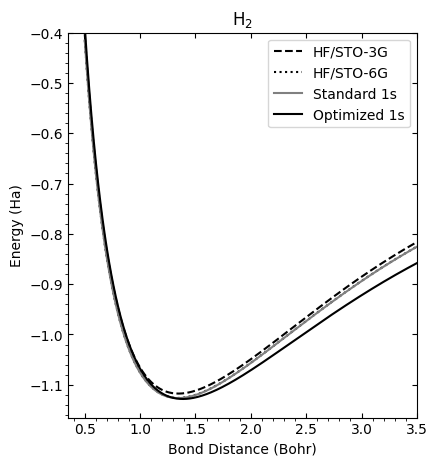

In [41]:
plt.figure(figsize=(4.5,5))
plt.plot(x, h2_sto3g, '--k', label='HF/STO-3G')
plt.plot(x, h2_sto6g, ':k', label='HF/STO-6G')
plt.plot(x, h2_hls, '-', color='gray', label='Standard 1s')
plt.plot(x, h2_hls_opt, '-', color='black', label='Optimized 1s')
plt.legend()
plt.title(r"H$_2$")
plt.xlabel("Bond Distance (Bohr)")
plt.ylabel("Energy (Ha)")
plt.xlim(right=3.5)
plt.ylim(top=-0.4)
plt.tick_params(direction='in', top=True, right=True)
plt.minorticks_on()
plt.show()


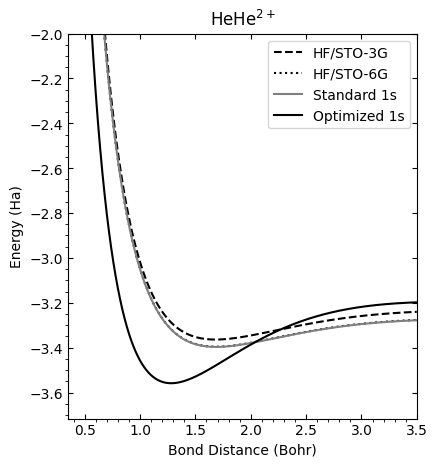

In [45]:
plt.figure(figsize=(4.5,5))
plt.plot(x, hehe_sto3g, '--k', label='HF/STO-3G')
plt.plot(x, hehe_sto6g, ':k', label='HF/STO-6G')
plt.plot(x, hehe_hls, '-', color='gray', label='Standard 1s')
plt.plot(x, hehe_hls_opt, '-', color='black', label='Optimized 1s')
plt.legend()
plt.title(r"HeHe$^{2+}$")
plt.xlabel("Bond Distance (Bohr)")
plt.ylabel("Energy (Ha)")
plt.xlim(right=3.5)
plt.ylim(top=-2.0)
plt.tick_params(direction='in', top=True, right=True)
plt.minorticks_on()
plt.show()


# HEH+

In [46]:
def KE(alpha, R):
    w = alpha * R
    c = 0.2372
    # c = 1
    numerator = alpha**2 * (1-4*c*K(w) - 8*c**2*K(w)*S(w) - 4*c**2*S(w)**2 + 2*c**2 - 4*c**3*K(w) + c**4)
    denominator = 1 + 4*c*S(w) + 4*c**2*S(w)**2 + 2*c**2 + 4*c**3*S(w) + c**4

    return numerator / denominator

def numerator1(Z, alpha, c, w):
    return 2*Z*(-alpha*(1 + 2*c*S(w) + c**2) + alpha*K(w)*(2*c + 4*c**2*S(w) + 2*c**3) + alpha*J(w)*(c**2 + 2*c**3*S(w) + c**4))

def numerator2(Z, alpha, c, w):
    return 2*Z*(-alpha*(c**2 + 2*c**3*S(w) + c**4) + alpha*K(w)*(2*c + 4*c**2*S(w) + 2*c**3) + alpha*J(w)*(1 + 2*c*S(w) + c**2))


def PE(alpha, R, Z1=None, Z2=None):
    w = alpha * R

    c = 0.2372
    # c = 1
    num1 = numerator1(Z1, alpha, c, w)
    num2 = numerator2(Z2, alpha, c, w)
    denum1 = 1 + 4*c*S(w) + 4*c**2*S(w)**2 + 2*c**2 + 4*c**3*S(w) + c**4

    num3 = alpha*(5/8*(1+c**4) + 4*L(w)*(c+c**3) + 2*c**2*J_(w) + 4*c**2*K_(w))

    return (num1 + num2 + num3) / denum1 + Z1*Z2/R

KE(1.8244, 1.44) + PE(1.8244, 1.44, 2, 1)

-2.9111422036757495